In [127]:
import sys
import os

import os
cwd = os.getcwd()
root_path = os.path.abspath('..')
sys.path.insert(0, root_path)


In [128]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils.fs import RESULTS_RAW_DIR

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from utils.enums import Perspective

In [129]:
def get_latest_run():
    def is_numeric(input):
        try:
            float(input)
            return True
        except ValueError:
            return False
        
    numeric_folders = [folder for folder in os.listdir(RESULTS_RAW_DIR) if is_numeric(folder) and os.path.isdir(os.path.join(RESULTS_RAW_DIR, folder))]

    if numeric_folders:
        highest_number = max(float(folder) for folder in numeric_folders)
        print(f"The latest run is: {highest_number}")
        return str(highest_number)
    else:
        print("No runs found.")
        return None

In [130]:
def load_results(run_name):
    run_path = os.path.join(RESULTS_RAW_DIR, run_name)
    npy_files = [file for file in os.listdir(run_path) if file.endswith('.npy')]

    loaded_data = {}

    # Load each .npy file and use the file name (without extension) as the key
    for npy_file in npy_files:
        file_path = os.path.join(run_path, npy_file)
        key = os.path.splitext(npy_file)[0]  # Get the file name without .npy extension
        loaded_data[key] = np.load(file_path)

        print(f"{loaded_data[key].shape} \t {key}")

    return loaded_data

In [131]:
bucket_lengths = [3,5,8,15]

latest_run = get_latest_run()
results = load_results(run_name=latest_run) 

# '1726688270.265151'   0.05 with 0 noise, batch size 8
# '1726683337.723001'   0.25 with 0 noise, batch size 8
# '1726688845.1876202'  0.05 with 0.25 noise, batch size 8
# '1726688947.9127235'  0.25 with 0.25 noise, batch size 8
# '1726689265.3127506'  0.05 with 1 noise, batch size 8
# '1726689364.887093'   0.25 with 1 noise, batch size 8
# '1726746216.6401465'  0.05 with 1 noise, batch size 1
# '1726746783.290876'   0.25 with 1 noise, batch size 1
# '1727098666.0037918'  first attempt multi task


The latest run is: 1727200629.5487735
(12034, 15, 10, 4) 	 labels_DAE_attribute_15
(5000, 15, 10, 4) 	 labels_DAE_attribute_3
(10000, 15, 10, 4) 	 labels_DAE_attribute_5
(14965, 15, 10, 4) 	 labels_DAE_attribute_8
(12034, 15, 4) 	 labels_DAE_event_15
(5000, 15, 4) 	 labels_DAE_event_3
(10000, 15, 4) 	 labels_DAE_event_5
(14965, 15, 4) 	 labels_DAE_event_8
(12034, 4) 	 labels_DAE_trace_15
(5000, 4) 	 labels_DAE_trace_3
(10000, 4) 	 labels_DAE_trace_5
(14965, 4) 	 labels_DAE_trace_8
(1505,) 	 losses_DAE_15
(625,) 	 losses_DAE_3
(1250,) 	 losses_DAE_5
(1871,) 	 losses_DAE_8
(12034, 15, 1) 	 result_DAE_attribute_Arrival Time_15
(5000, 3, 1) 	 result_DAE_attribute_Arrival Time_3
(10000, 5, 1) 	 result_DAE_attribute_Arrival Time_5
(14965, 8, 1) 	 result_DAE_attribute_Arrival Time_8
(12034, 15, 4) 	 result_DAE_attribute_Attribute_15
(5000, 3, 4) 	 result_DAE_attribute_Attribute_3
(10000, 5, 4) 	 result_DAE_attribute_Attribute_5
(14965, 8, 4) 	 result_DAE_attribute_Attribute_8
(12034, 15, 1) 	

In [132]:
# Check the amount of anomalies of each type are present
print(np.sum(results['labels_DAE_trace_8'][:,0] == 1))
print(np.sum(results['labels_DAE_trace_8'][:,1] == 1))
print(np.sum(results['labels_DAE_trace_8'][:,2] == 1))
print(np.sum(results['labels_DAE_trace_8'][:,3] == 1))

print(len(results['labels_DAE_trace_8']))

994
1349
1166
14903
14965


In [133]:
def plot_losses(results, labels, perspective, level, bucket=None, zoom=[[11000,13000],[-0.05, 0.2]]):
    def scatter_plot(ax, results, labels):
        y_values = results
        x_values = np.arange(len(results))
        ax.scatter(x_values[labels == 0], y_values[labels == 0], c='grey', s=3, label='Normal Prefixes', zorder=1)
        ax.scatter(x_values[labels == 1], y_values[labels == 1], c='red', s=3, label='Anomalous Prefixes', zorder=2)
        ax.grid(True)

    fig, ax = plt.subplots(figsize=(15, 6))

    labels = labels[:, perspective]
    scatter_plot(ax, results, labels)
    
    perspective_name = Perspective.values()[perspective]

    bucket_string = ''
    if bucket is not None:
        bucket_string = f'with bucket size {str(bucket)}'
    plt.title(f'Error per Prefix on the {perspective_name} perspective and {level} level {bucket_string}')
    plt.xlabel('Prefix Index')
    plt.ylabel('Loss')
    
    if zoom:
        axins = inset_axes(ax, width="60%", height="60%", loc='upper right')

        scatter_plot(axins, results, labels)
        axins.set_xlim(zoom[0])
        axins.set_ylim(zoom[1])
        _,_ = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=3)

    plt.xlabel('Batch Index')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def bucket_plot_losses(results_name, labels_name, perspective, level, zoom=[[11000,13000],[-0.05, 0.2]]):
    for bucket in bucket_lengths:
        plot_losses(
            results=results[f'{results_name}_{bucket}'], 
            labels=results[f'{labels_name}_{bucket}'], 
            perspective=perspective, level=level, bucket=bucket, zoom=zoom)


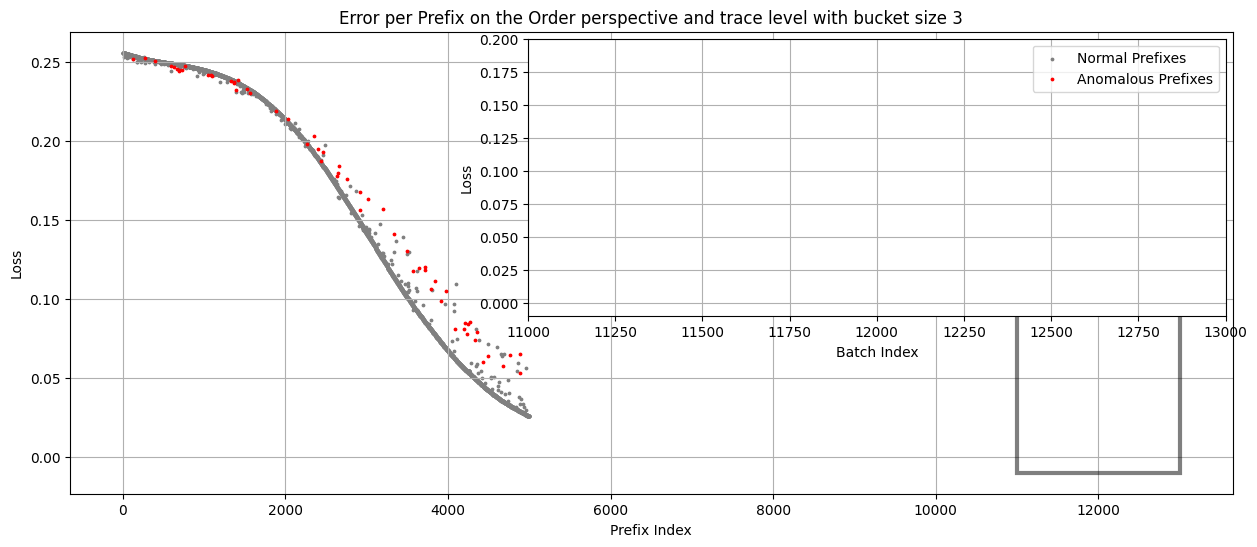

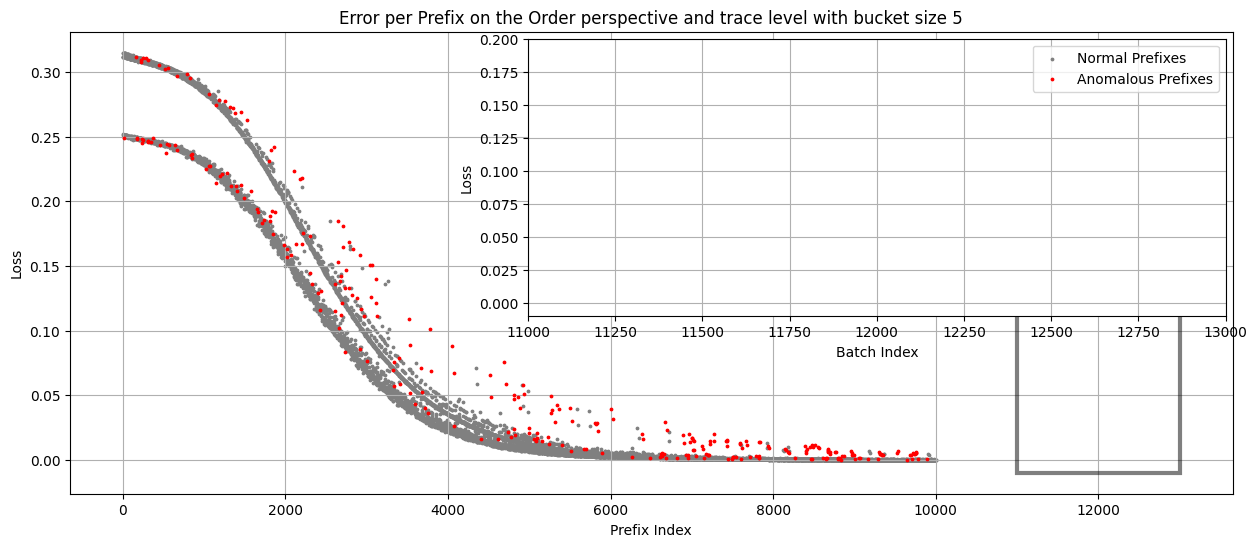

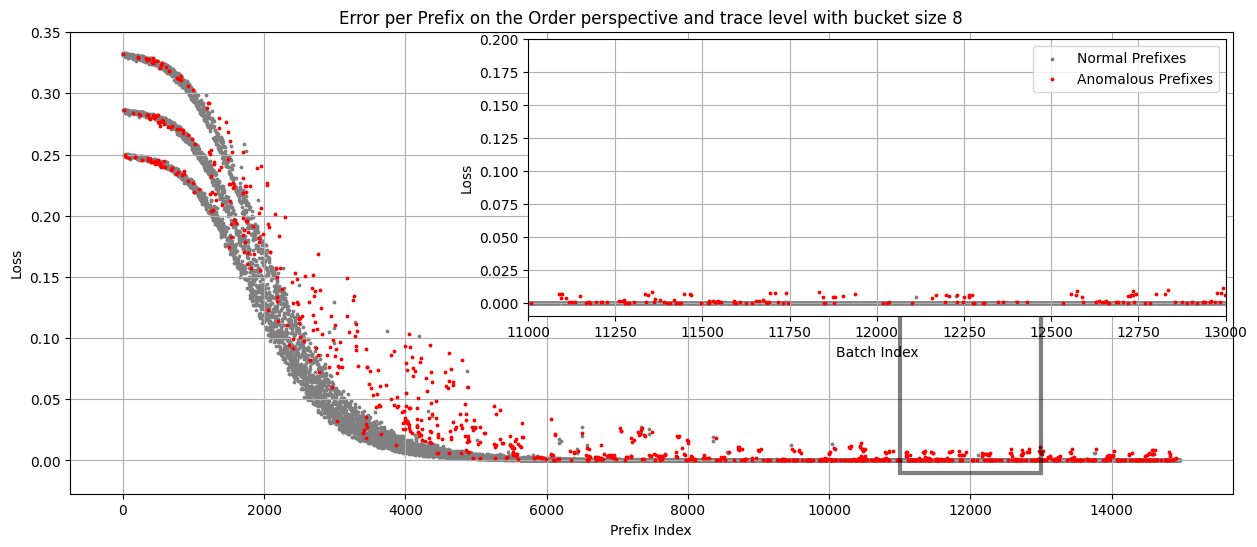

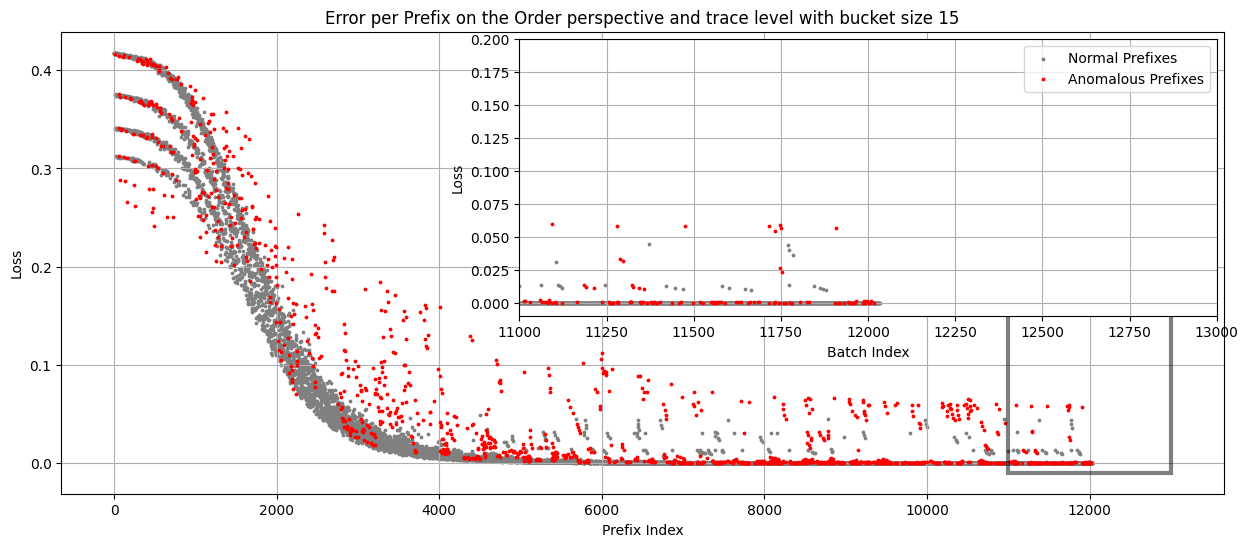

In [134]:
bucket_plot_losses(
    results_name='result_DAE_trace_Order', 
    labels_name='labels_DAE_trace',
    perspective=Perspective.ORDER,
    level='trace',
    zoom=[[11000,13000],[-0.01, 0.2]])

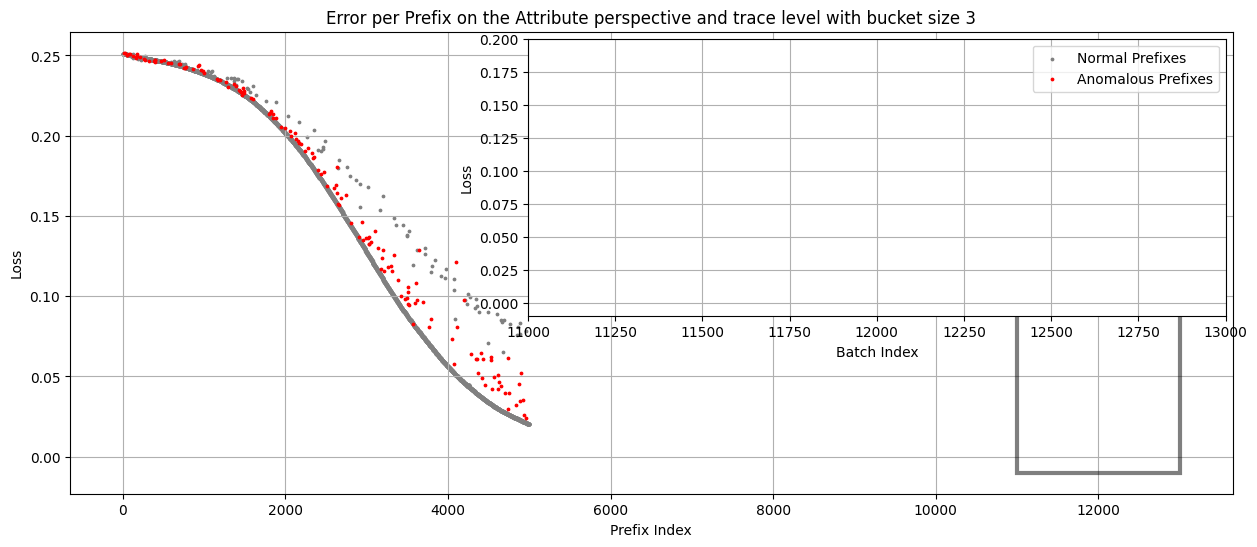

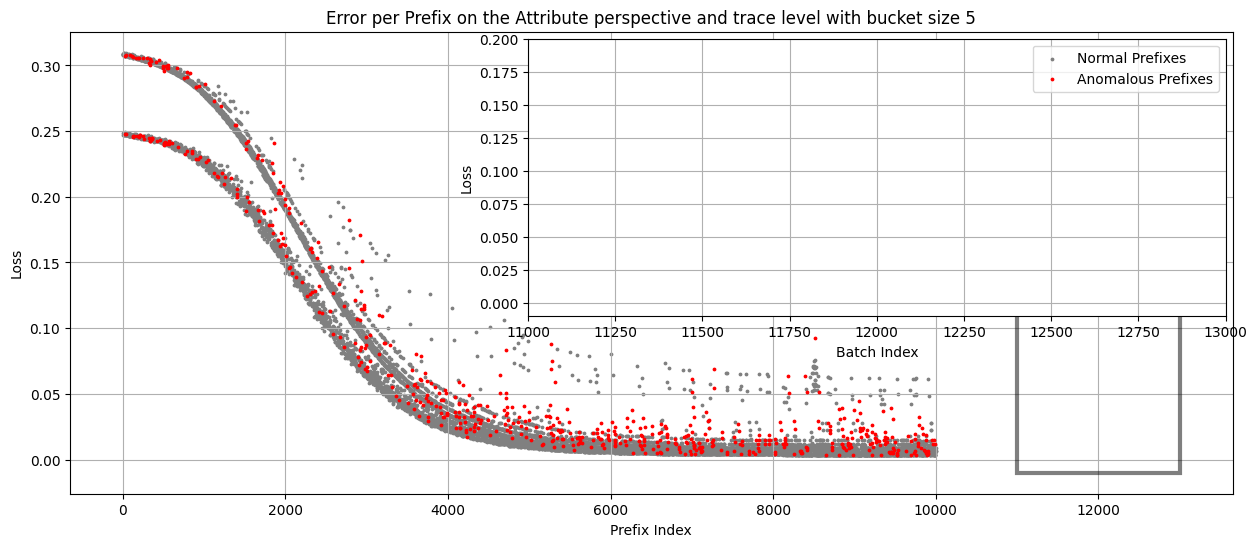

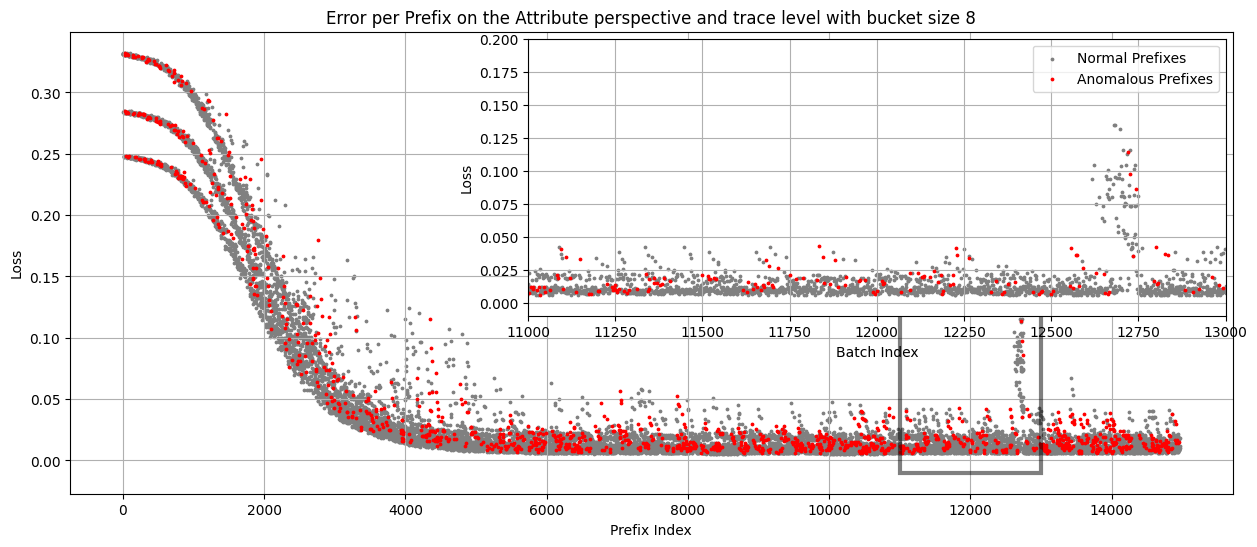

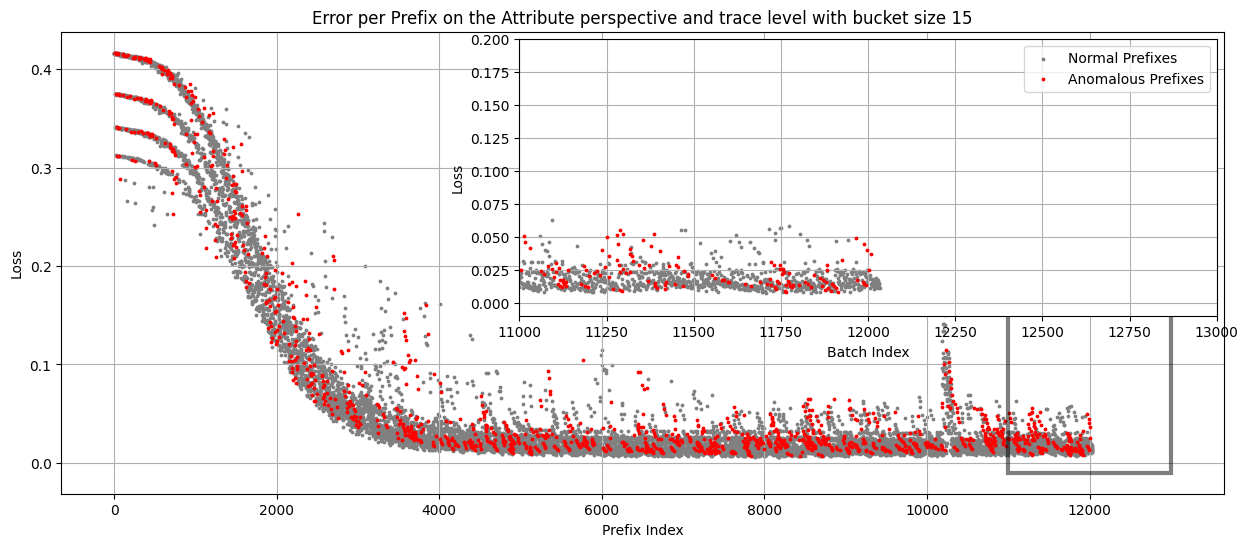

In [135]:
bucket_plot_losses(
    results_name='result_DAE_trace_Attribute', 
    labels_name='labels_DAE_trace',
    perspective=Perspective.ATTRIBUTE,
    level='trace',
    zoom=[[11000,13000],[-0.01, 0.2]])

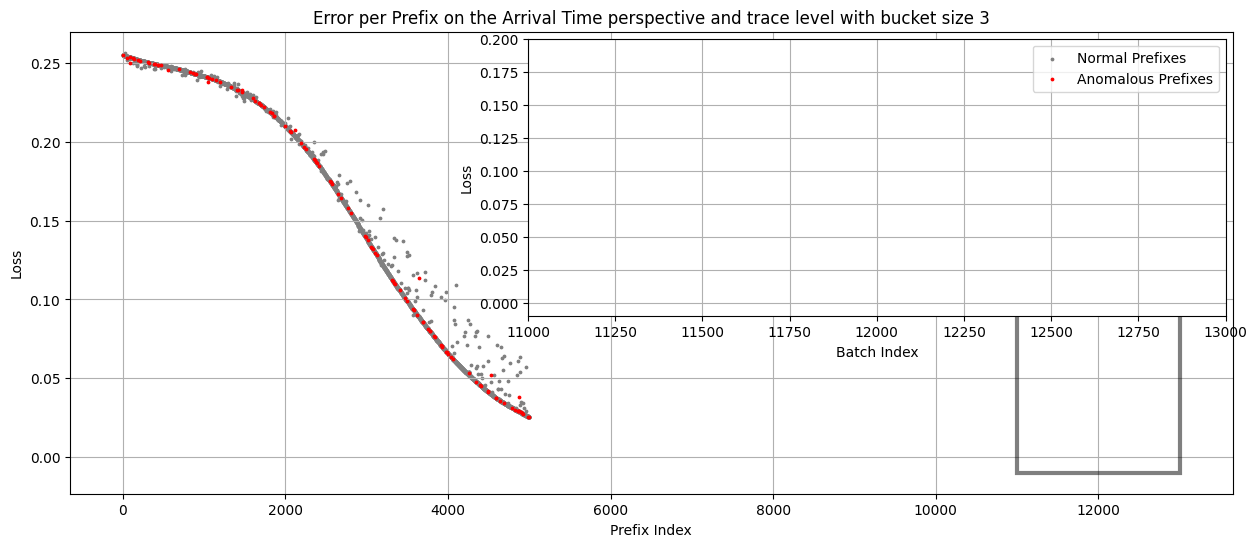

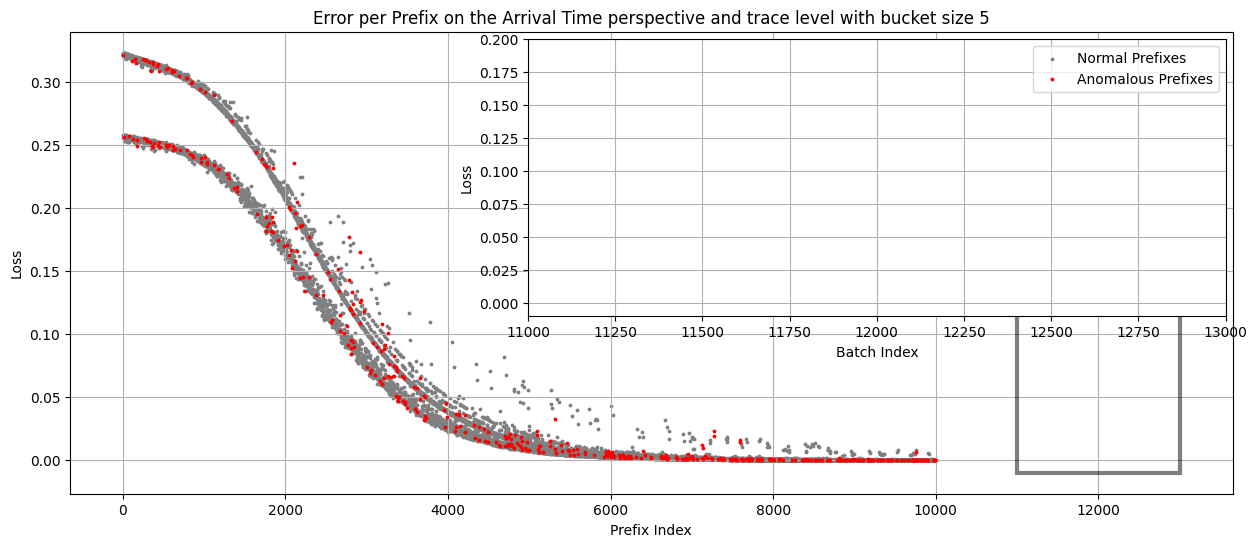

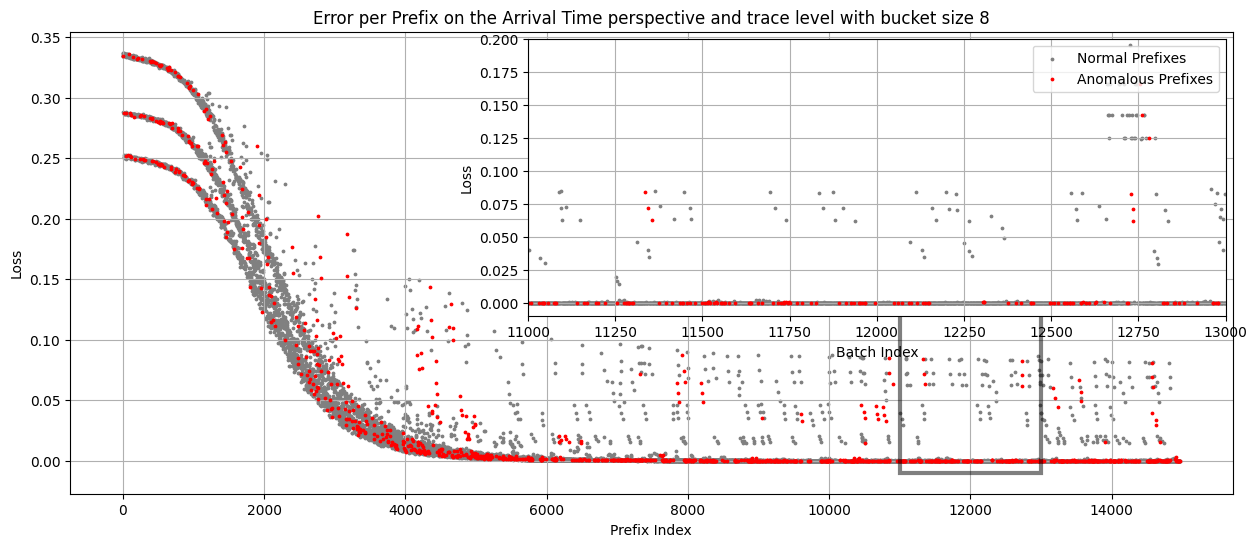

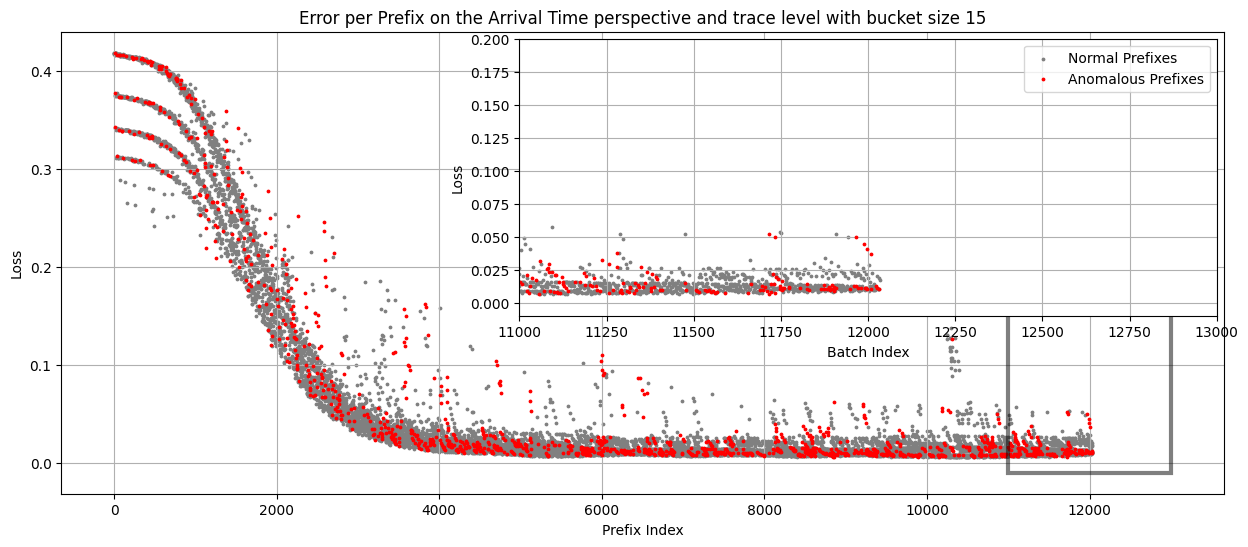

In [136]:
bucket_plot_losses(
    results_name='result_DAE_trace_Arrival Time', 
    labels_name='labels_DAE_trace',
    perspective=Perspective.ARRIVAL_TIME,
    level='trace',
    zoom=[[11000,13000],[-0.01, 0.2]])

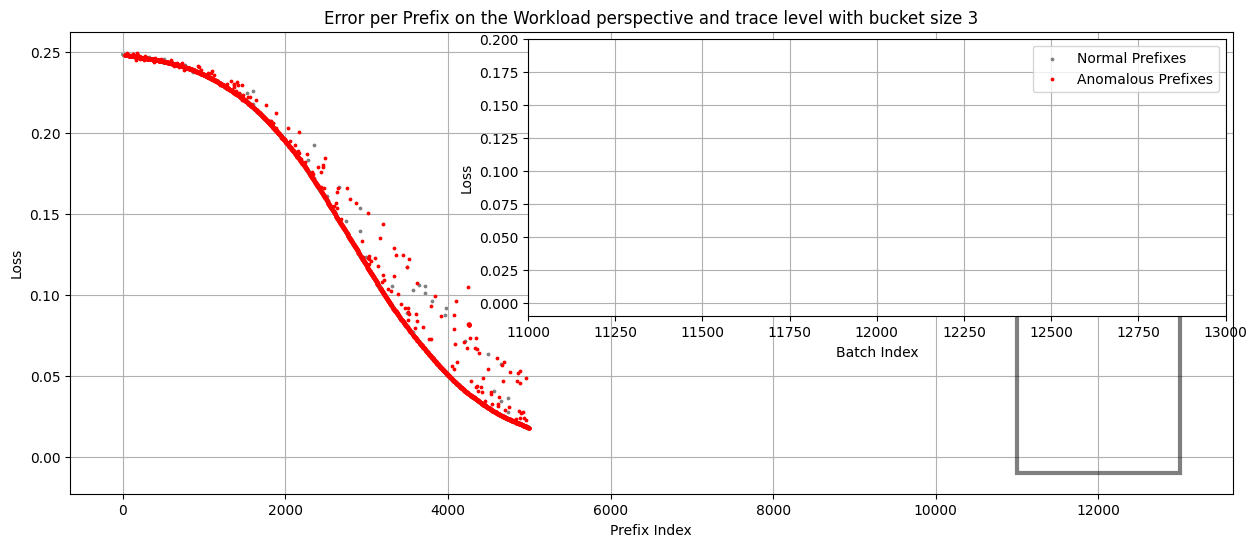

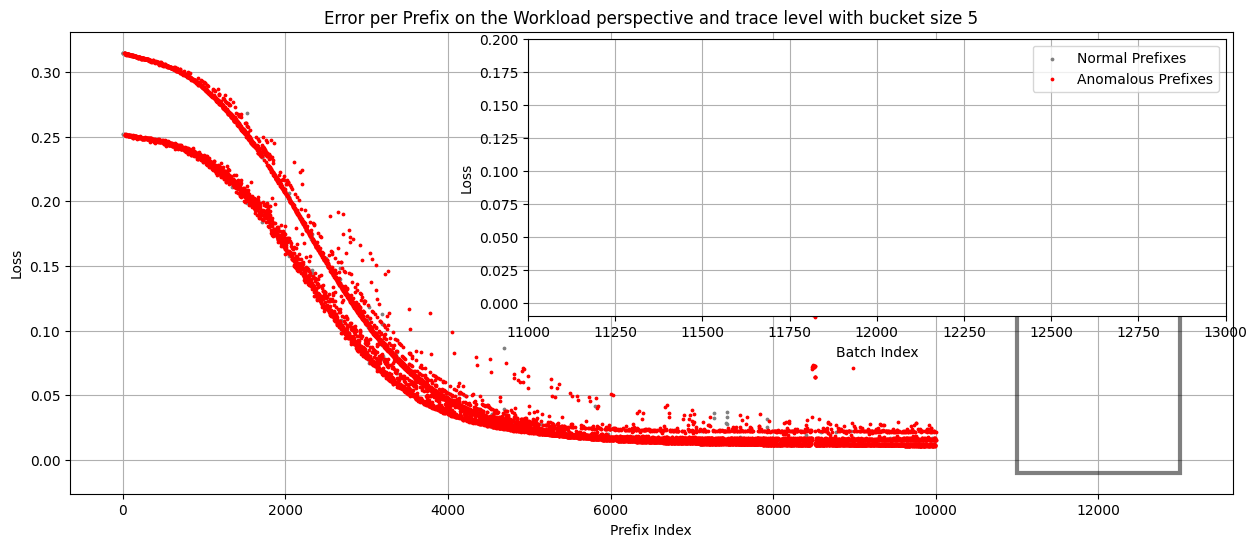

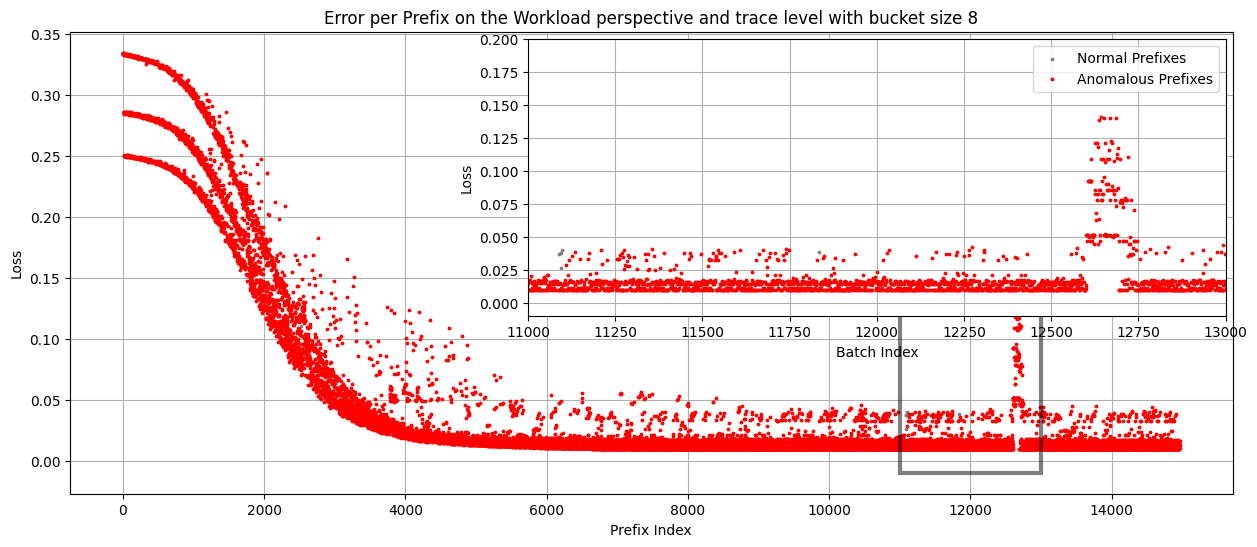

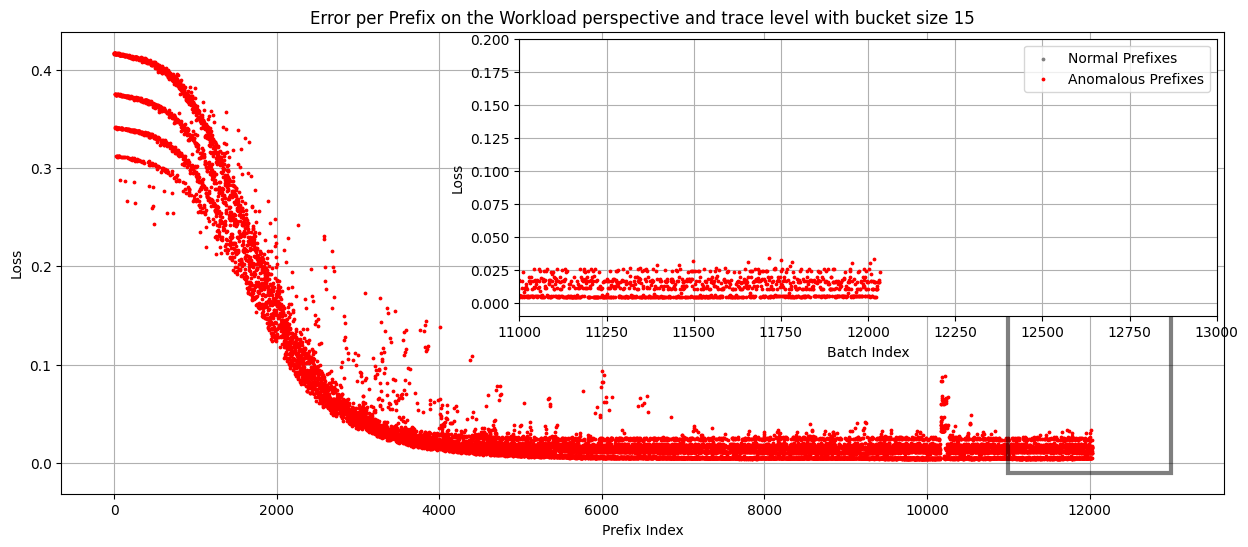

In [137]:
bucket_plot_losses(
    results_name='result_DAE_trace_Workload', 
    labels_name='labels_DAE_trace',
    perspective=Perspective.WORKLOAD,
    level='trace',
    zoom=[[11000,13000],[-0.01, 0.2]])

In [138]:
results['result_DAE_event_Order'].reshape(-1, 1).shape

KeyError: 'result_DAE_event_Order'

In [95]:
results['labels_DAE_event'].reshape(-1, 4).shape

(629985, 4)

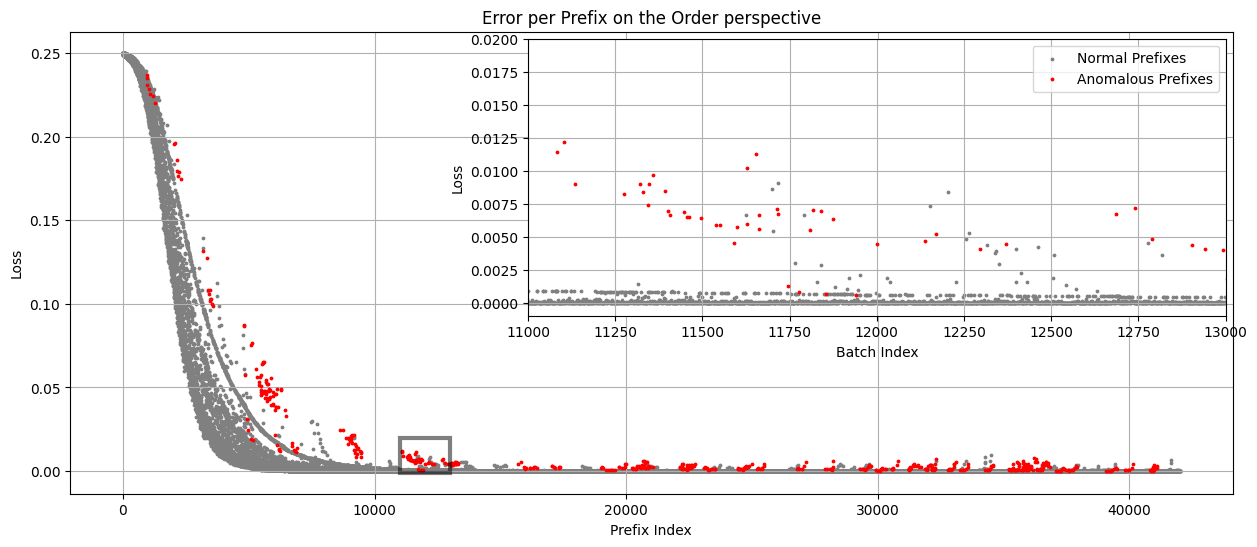

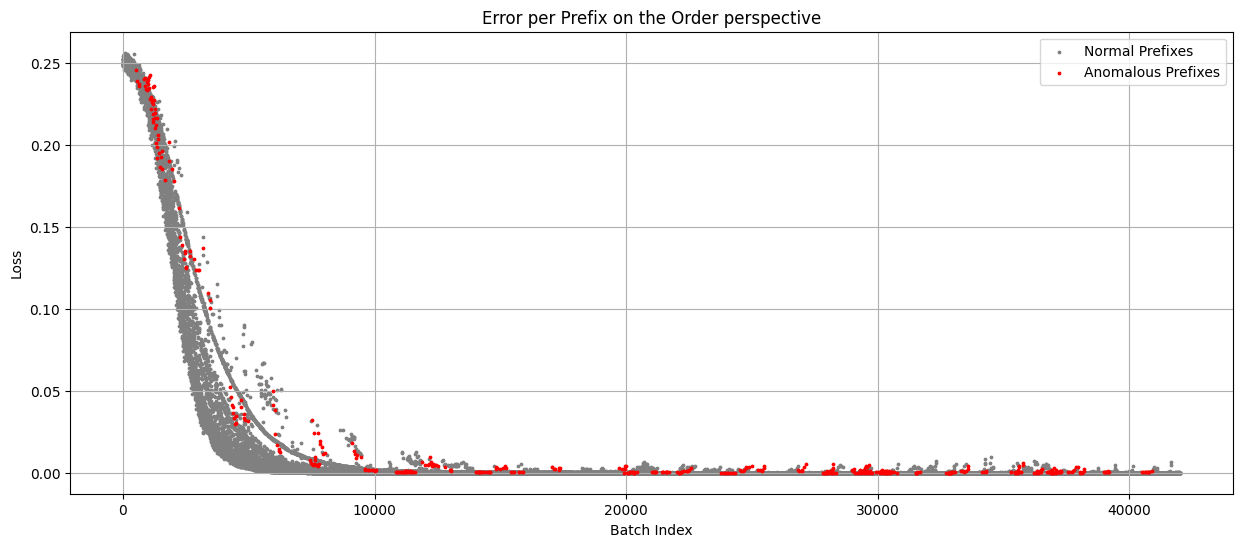

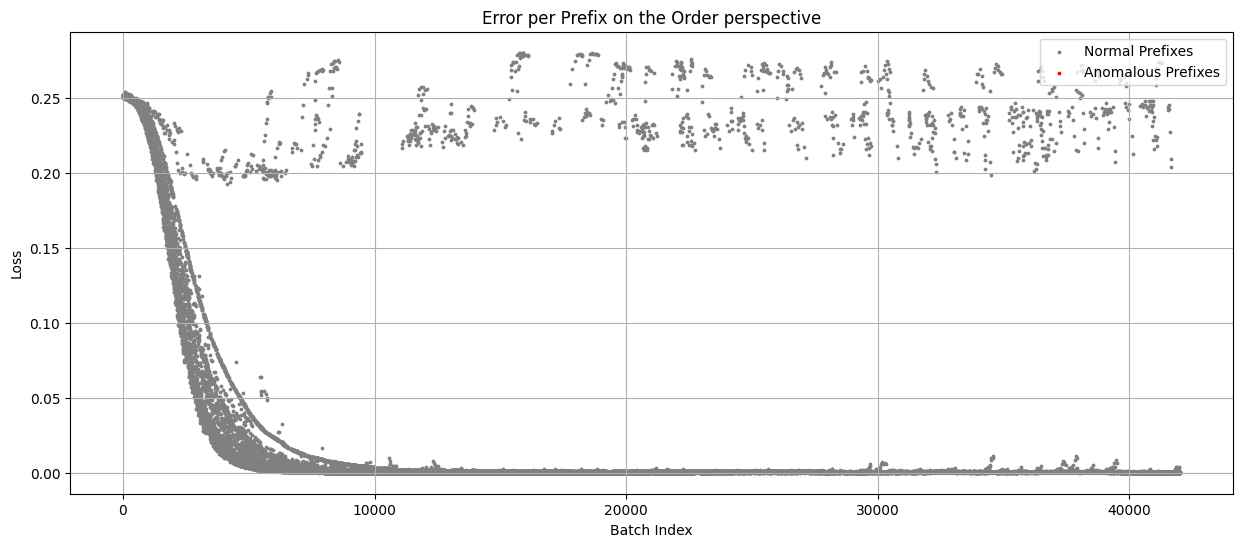

In [96]:
event_index = 0
plot_losses_fancy(
    results=results['result_DAE_event_Order'][:,event_index], 
    labels=results['labels_DAE_event'][:,event_index], 
    perspective=Perspective.ORDER,
    zoom=[[11000,13000],[-0.001, 0.02]])
event_index = 1
plot_losses_fancy(
    results=results['result_DAE_event_Order'][:,event_index], 
    labels=results['labels_DAE_event'][:,event_index], 
    perspective=Perspective.ORDER,
    zoom=None)
event_index = 12
plot_losses_fancy(
    results=results['result_DAE_event_Order'][:,event_index], 
    labels=results['labels_DAE_event'][:,event_index], 
    perspective=Perspective.ORDER,
    zoom=None)

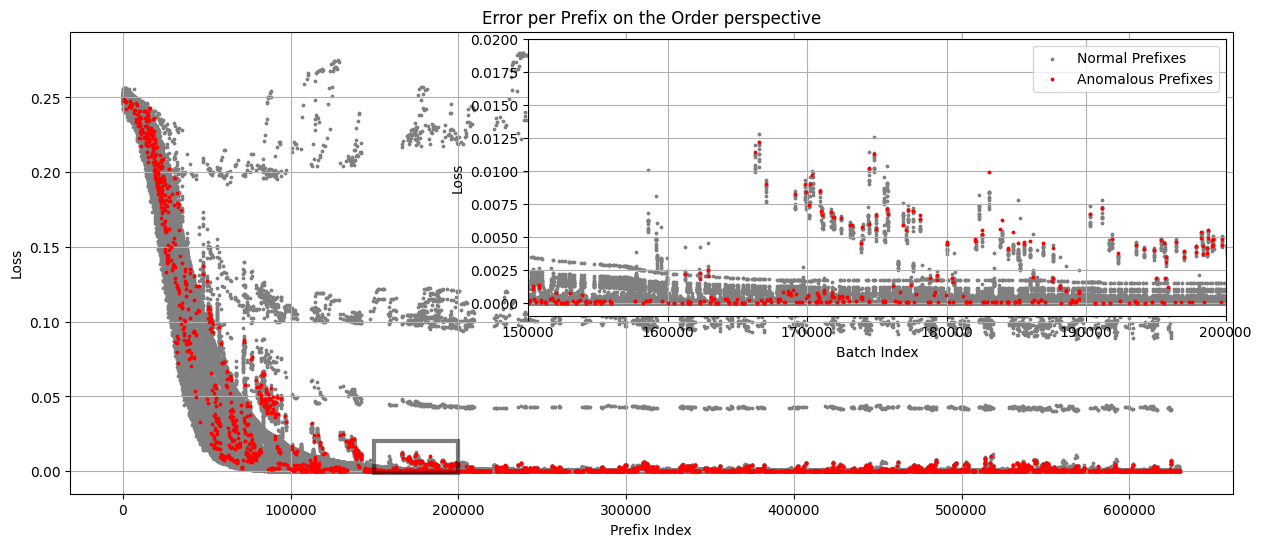

In [97]:
plot_losses_fancy(
    results=results['result_DAE_event_Order'].reshape(-1, 1), 
    labels=results['labels_DAE_event'].reshape(-1, 4), 
    perspective=Perspective.ORDER,
    zoom=[[150000,200000],[-0.001, 0.02]])

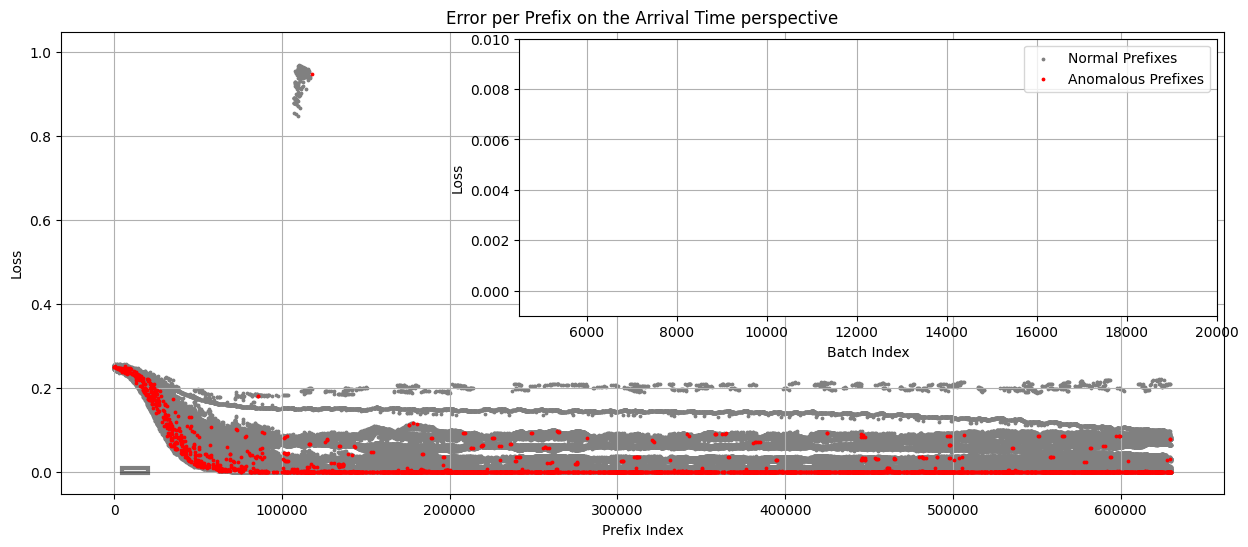

In [98]:
plot_losses_fancy(
    results=results['result_DAE_event_Arrival Time'].reshape(-1, 1), 
    labels=results['labels_DAE_event'].reshape(-1, 4), 
    perspective=Perspective.ARRIVAL_TIME,
    zoom=[[4500,20000],[-0.001, 0.01]])